train.csv - выборка, которую поделим на обучающую и тестовую в соотношении 80/20

date - Дата в формате ГОД-МЕСЯЦ\
street_id - номер улицы\
build_tech - сторительная методика\
floor - кол-во этажей\
area - площадь\
rooms - кол-во комнат\
balcon - кол-во балконов\
metro_dist - расстояние от метро\
g_lift - наличие лифта\
n_photos - кол-во фото в объявлении\
kw1-kw13 - район Highland

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

### Analysis

In [268]:
data = pd.read_csv('train.csv')
data.shape

(100000, 25)

Удаляем id внутри датасета

In [269]:
del data['id']

In [270]:
data.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,3335000


In [271]:
pd.concat({'Object type':data.dtypes, 'Null count':data.isnull().sum()}, axis=1)

,Object type,Null count
date,object,0
street_id,int64,0
build_tech,float64,29735
floor,int64,0
area,int64,0
rooms,int64,0
balcon,int64,0
metro_dist,float64,4896
g_lift,float64,29992
n_photos,int64,0


In [272]:
data['build_tech'].unique(), data['g_lift'].unique(), data['date'].unique()

(array([nan,  0.,  1.,  2.]),
 array([ 1., nan,  0.]),
 array(['2011-1', '2011-10', '2011-11', '2011-12', '2011-2', '2011-3',
        '2011-4', '2011-5', '2011-6', '2011-7', '2011-8', '2011-9',
        '2012-1', '2012-10', '2012-11', '2012-12', '2012-2', '2012-3'],
       dtype=object))

Удаляем дубликаты

In [273]:
data.drop_duplicates()
data.shape

(100000, 24)

Заполняем пропуски модами и средним с группировкой по id улицы\
build_tech и g_lift - мода\
metro_dist - среднее

In [274]:
def fill_nans(data):
    my_mode = lambda x: x.mode()[0]
    stat = data.groupby(['street_id']).agg({'build_tech': [my_mode], 'metro_dist': ['mean'], 'g_lift': [my_mode]}).reset_index()
    stat.columns = ['street_id', 'build_tech', 'metro_dist', 'g_lift']
    
    features = ['build_tech', 'metro_dist', 'g_lift']
    for _, row in stat.iterrows():
        data.loc[data['street_id'] == row['street_id'], features] = \
        data.loc[data['street_id'] == row['street_id'], features]\
            .fillna(row[features].squeeze(axis=0))
    return data

In [275]:
data = fill_nans(data)

In [276]:
data.isnull().sum()

date          0
street_id     0
build_tech    0
floor         0
area          0
rooms         0
balcon        0
metro_dist    0
g_lift        0
n_photos      0
kw1           0
kw2           0
kw3           0
kw4           0
kw5           0
kw6           0
kw7           0
kw8           0
kw9           0
kw10          0
kw11          0
kw12          0
kw13          0
price         0
dtype: int64

<Axes: xlabel='price', ylabel='Count'>

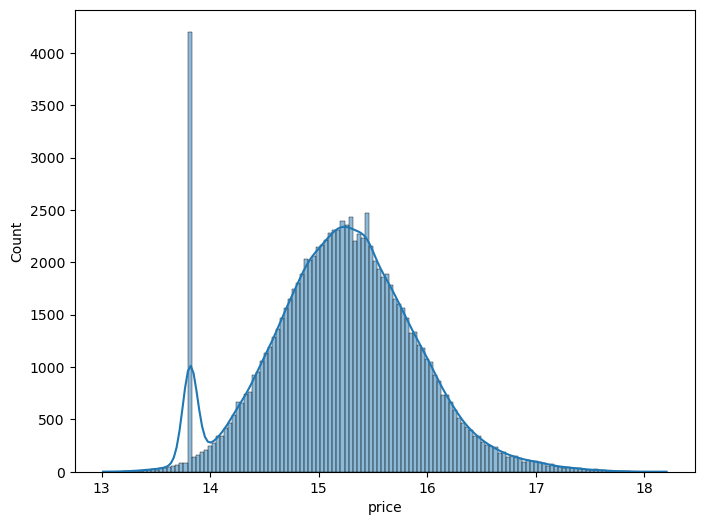

In [277]:
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(np.log(data['price']), kde=True)

(950000.0, 1030000.0)

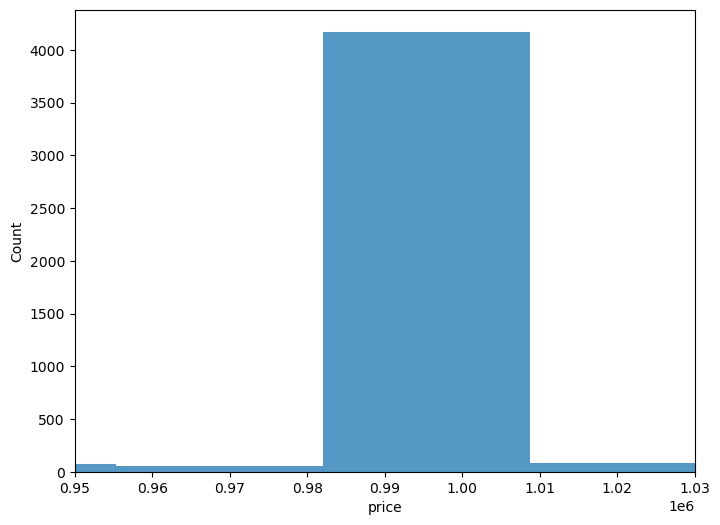

In [278]:
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data['price'], bins=3000)
plt.xlim(9.5e5, 1.03e6)

In [279]:
data[(data['price'] > 0.98e6) & (data['price'] < 1.01e6)].shape

(4178, 24)

In [280]:
data[data['price'] == 1e6].shape

(4079, 24)

Нужно сократь количество сэмплов с ценой 1 млн. долларов

In [281]:
data = data.drop(data[data['price'] == 1e6].sample(frac=0.97, random_state=18).index).reset_index(drop=True)
data[data['price'] == 1e6].shape

(122, 24)

<Axes: xlabel='price', ylabel='Count'>

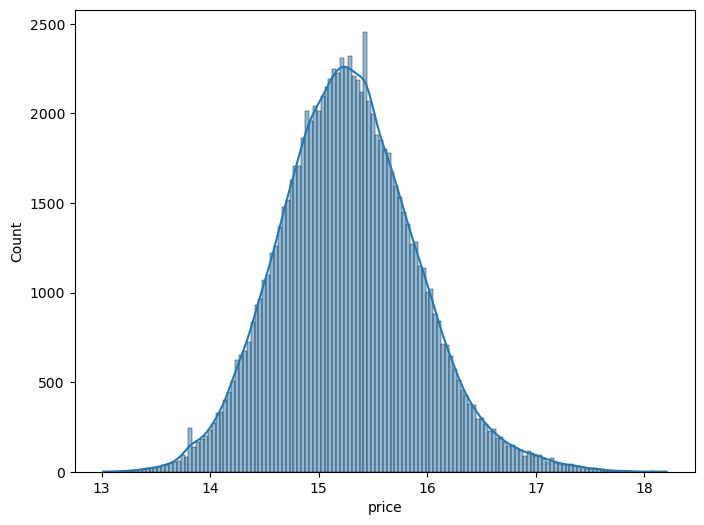

In [282]:
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(np.log(data['price']), kde=True)

Видим, что целевой признак стоит прологарифмировать

In [283]:
data['price'] = np.log(data['price'])

Удалим несколько выбросов

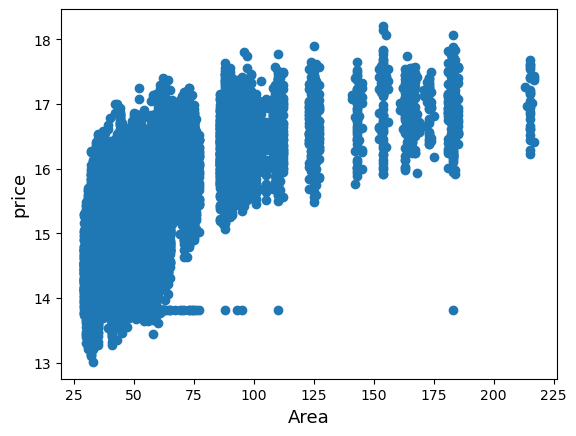

In [284]:
fig, ax = plt.subplots()
ax.scatter(x = data['area'], y = data['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('Area', fontsize=13)
plt.show()

In [285]:
data = data.drop(data[(data['price'] < 14) & (data['area'] > 82)].index).reset_index(drop=True)

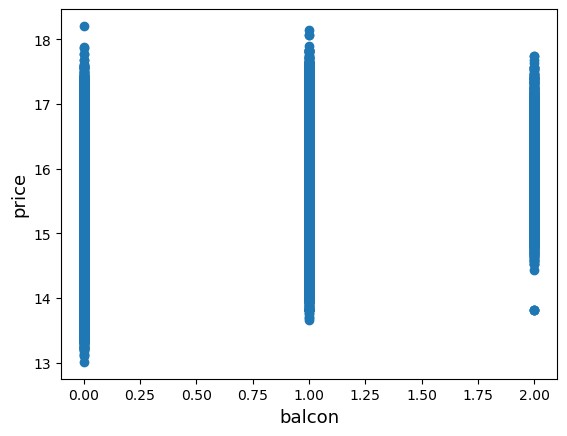

In [286]:
fig, ax = plt.subplots()
ax.scatter(x = data['balcon'], y = data['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('balcon', fontsize=13)
plt.show()

In [287]:
data = data.drop(data[(data['price'] <= 14) & (data['balcon'] == 2)].index).reset_index(drop=True)
data = data.drop(data[(data['price'] > 18) & (data['balcon'] == 0)].index).reset_index(drop=True)
#data = data.drop(data[(data['price'] >= 18) & (data['balcon'] == 1)].index).reset_index(drop=True)

Закодируем дату и отмасштабируем числовые признаки

In [288]:
label_en = LabelEncoder()
data['date'] = label_en.fit_transform(data['date'])

In [289]:
features_to_scale = list(data.columns[:10])

minmax_scale = MinMaxScaler()
scaled_data = minmax_scale.fit_transform(data[features_to_scale])

In [290]:
# Добавим масштабированные данные в набор данных
for i in range(len(features_to_scale)):
    col = features_to_scale[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = scaled_data[:, i]

In [291]:
data.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,date_scaled,street_id_scaled,build_tech_scaled,floor_scaled,area_scaled,rooms_scaled,balcon_scaled,metro_dist_scaled,g_lift_scaled,n_photos_scaled
0,0,560,1.0,2,59,3,0,30.0,1.0,5,...,0.0,0.834575,0.5,0.041667,0.159574,0.4,0.0,1.000000,1.0,0.454545
1,0,667,0.0,10,50,2,1,25.0,1.0,1,...,0.0,0.994039,0.0,0.375000,0.111702,0.2,0.5,0.833333,1.0,0.090909
2,0,90,0.0,1,48,2,0,25.0,0.0,1,...,0.0,0.134128,0.0,0.000000,0.101064,0.2,0.0,0.833333,0.0,0.090909
3,0,94,1.0,3,62,3,1,30.0,0.0,3,...,0.0,0.140089,0.5,0.083333,0.175532,0.4,0.5,1.000000,0.0,0.272727
4,0,232,0.0,3,60,3,0,25.0,0.0,3,...,0.0,0.345753,0.0,0.083333,0.164894,0.4,0.0,0.833333,0.0,0.272727


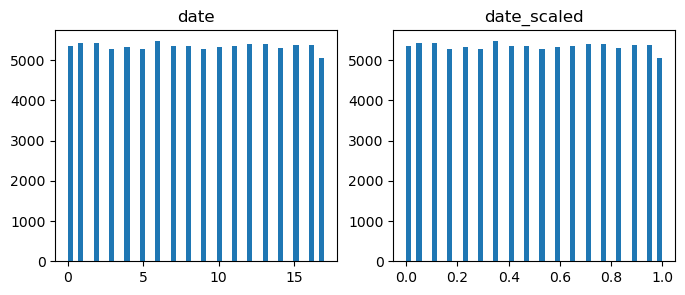

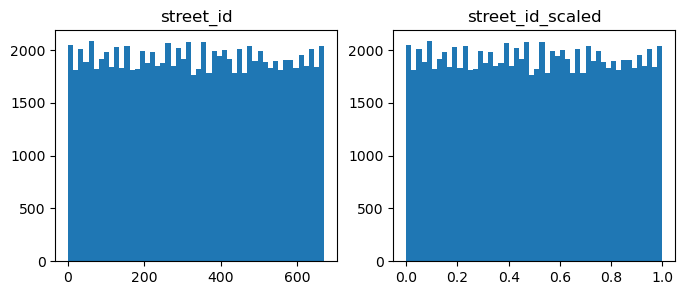

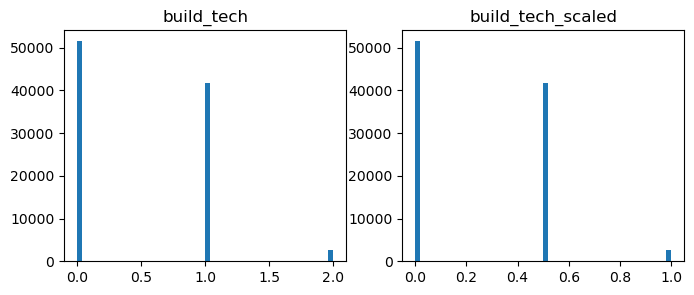

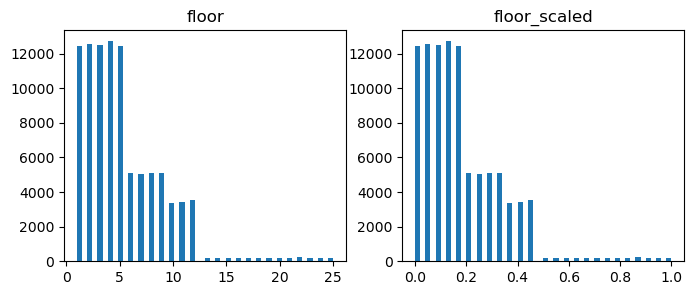

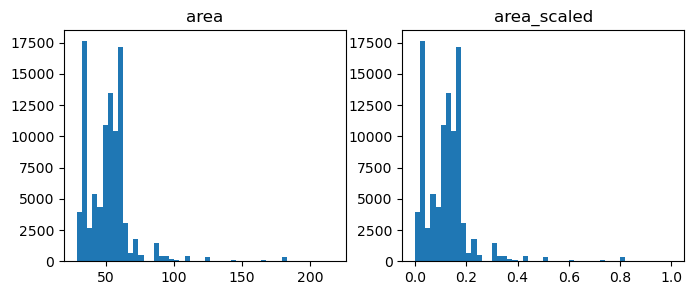

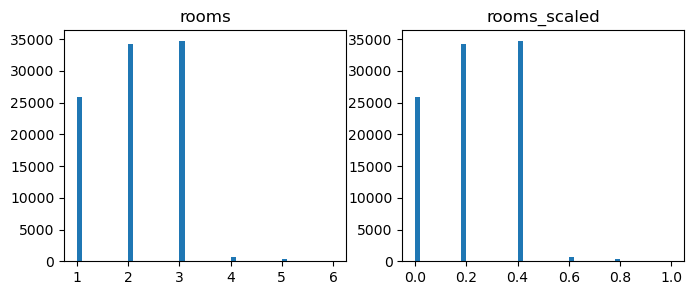

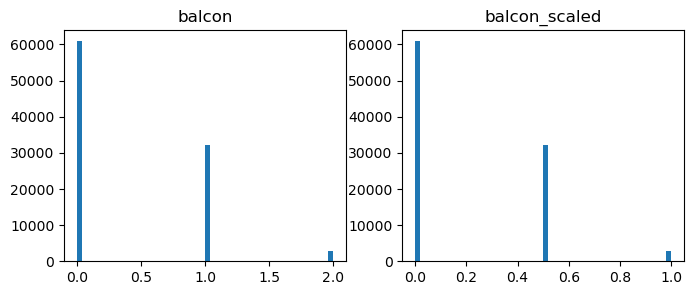

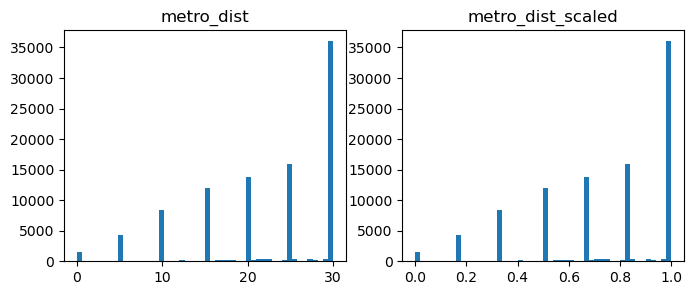

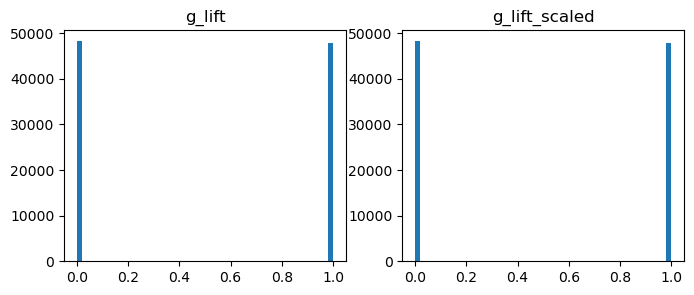

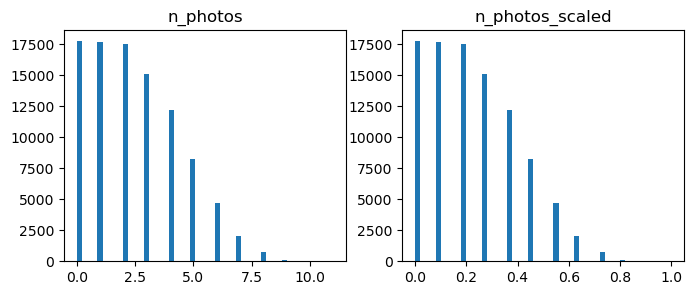

In [292]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in features_to_scale:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

In [293]:
# Заменим оригинальные столбцы на отмасштабированные
for i in range(len(features_to_scale)):
    col = features_to_scale[i]
    scaled_col = col + '_scaled'
    data[col] = data[scaled_col]
    del data[scaled_col]

In [294]:
data.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0.0,0.834575,0.5,0.041667,0.159574,0.4,0.0,1.000000,1.0,0.454545,...,0,0,0,0,0,0,0,0,0,15.321808
1,0.0,0.994039,0.0,0.375000,0.111702,0.2,0.5,0.833333,1.0,0.090909,...,0,0,0,0,0,0,0,0,0,16.398073
2,0.0,0.134128,0.0,0.000000,0.101064,0.2,0.0,0.833333,0.0,0.090909,...,0,0,0,0,0,0,0,0,0,14.512650
3,0.0,0.140089,0.5,0.083333,0.175532,0.4,0.5,1.000000,0.0,0.272727,...,0,0,0,0,0,0,0,0,0,16.355537
4,0.0,0.345753,0.0,0.083333,0.164894,0.4,0.0,0.833333,0.0,0.272727,...,0,0,0,0,0,0,0,0,0,15.019983


<Axes: >

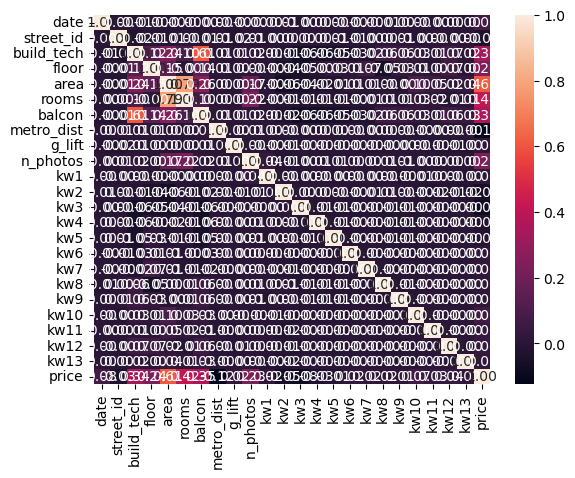

In [295]:
sns.heatmap(data.corr(), annot=True, fmt='.2f')

По цвету видно, что kw1-kw13 почти не коррелируют с целевым признаком.

<Axes: >

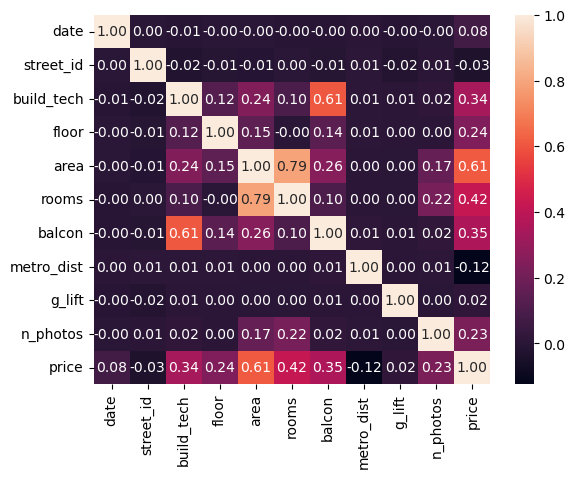

In [296]:
sns.heatmap(data.drop(columns=data.columns[10:23]).corr(), annot=True, fmt='.2f')

Самая высокая корреляция цены с признаком area

Отделим целевой признак

In [297]:
features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'g_lift', 'n_photos']

In [298]:
X = data.drop(columns=['price'])[features]
y = data['price']

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

### Mertics

В качестве метрик будем использовать:\
- mean_absolute_error
- mean_squared_error
- r2_score

### Models

В качестве моделей будем использовать:\
- Линейная регрессия
- Метод ближайших соседей
- Дерево решений
- Случайный лес
- Градиентный бустинг

### Baseline

In [300]:
class MetricLogger:

    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
             'alg': pd.Series([], dtype='str'),
             'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric'] == metric) & (self.df['alg'] == alg)].index, inplace=True)
        # Добавление нового значения
        temp = [{'metric': metric, 'alg': alg, 'value': value}]
        self.df = self.df._append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric'] == metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values

    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5,
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a, b in zip(pos, array_metric):
            plt.text(0.5, a - 0.05, str(round(b, 3)), color='white')
        plt.show()

In [301]:
regr_models = {'LR': LinearRegression(), 
               'KNN':KNeighborsRegressor(n_neighbors=3),
               'DecTree':DecisionTreeRegressor(random_state=18),
               'RF':RandomForestRegressor(random_state=5),
               'GB':GradientBoostingRegressor(random_state=18)}

In [302]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [303]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(np.e ** y_test, np.e ** y_pred)
    mse = mean_squared_error(np.e ** y_test, np.e ** y_pred)
    r2 = r2_score(np.e ** y_test, np.e ** y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('{} \t MAE={}, MSE={}, R2={}'.format(
        model_name, round(mae, 3), round(mse, 3), round(r2, 3)))

In [304]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

LR 	 MAE=1981525.887, MSE=18136944605952.8, R2=-0.065
KNN 	 MAE=2002516.682, MSE=9709666308670.92, R2=0.43
DecTree 	 MAE=1822278.083, MSE=9423106408901.23, R2=0.446
RF 	 MAE=1386620.981, MSE=5219583917293.45, R2=0.693
GB 	 MAE=1584528.462, MSE=6434715079322.125, R2=0.622


### GridSearch

Метод k-ближайших соседей

In [307]:
neighbor_params = [{'n_neighbors': range(10, 50, 5)}]
neighbor_search = GridSearchCV(KNeighborsRegressor(), neighbor_params, cv=3, scoring='neg_mean_squared_error')
neighbor_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': range(10, 50, 5)}],
             scoring='neg_mean_squared_error')

In [308]:
neighbor_search.best_params_

{'n_neighbors': 20}

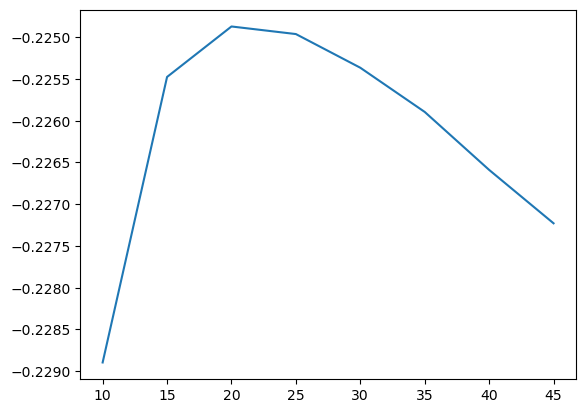

In [309]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(neighbor_params[0]['n_neighbors'], neighbor_search.cv_results_['mean_test_score'])

Дерево решений

In [316]:
tree_params = {
    'max_depth': [8, 9, 10, 11, 12],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [0.6, 0.8, 1.0]
}

In [317]:
tree_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=18),
                    param_grid=tree_params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
tree_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=18), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11, 12],
                         'max_features': [0.6, 0.8, 1.0],
                         'min_samples_leaf': [1, 2, 3, 4, 5]},
             scoring='neg_mean_squared_error')

In [318]:
tree_search.best_params_

{'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 5}

Случайный лес

In [327]:
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [14, 15, None],
    'min_samples_leaf': [1, 2],
}

In [328]:
rf_search = GridSearchCV(estimator=RandomForestRegressor(random_state=5),
                    param_grid=rf_params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [14, 15, None],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 150]},
             scoring='neg_mean_squared_error')

In [329]:
rf_search.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}

Градиентный бустинг

In [331]:
gb_params = {
    'n_estimators': [100, 150],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.5, 0.8, 1, 1.2]
}

In [332]:
gb_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=18),
                    param_grid=gb_params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gb_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=18),
             n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.8, 1, 1.2],
                         'max_depth': [4, 5, 6], 'n_estimators': [100, 150]},
             scoring='neg_mean_squared_error')

In [336]:
gb_search.best_params_

{'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 150}

### Apply best params

In [337]:
best_regr_models = {'KNN_best':KNeighborsRegressor(n_neighbors=20),
                    'DecTree_best':DecisionTreeRegressor(max_depth=10, max_features=1.0, min_samples_leaf=5, random_state=18),
                    'RF_best':RandomForestRegressor(n_estimators=150, random_state=5),
                    'GB_best':GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.8, random_state=18)}

In [338]:
for model_name, model in best_regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

KNN_best 	 MAE=1886374.781, MSE=9390502343333.979, R2=0.448
DecTree_best 	 MAE=1652217.684, MSE=6977411423587.107, R2=0.59
RF_best 	 MAE=1383863.983, MSE=5208914820975.069, R2=0.694
GB_best 	 MAE=630498.05, MSE=1129200642683.104, R2=0.934


### Comparison and conclusion

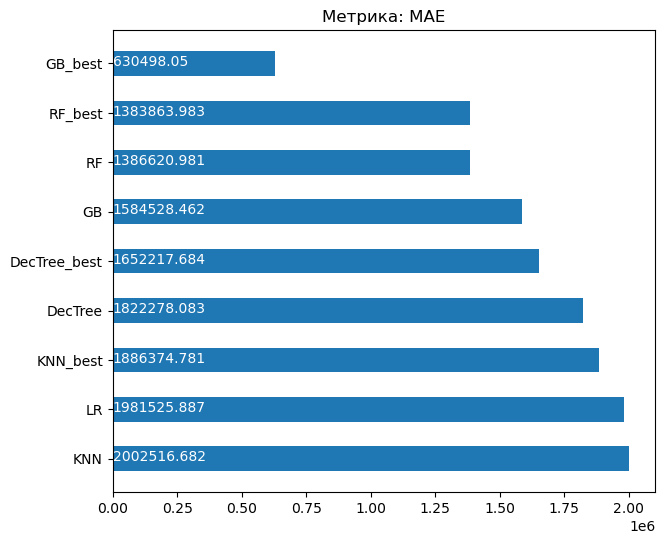

In [339]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

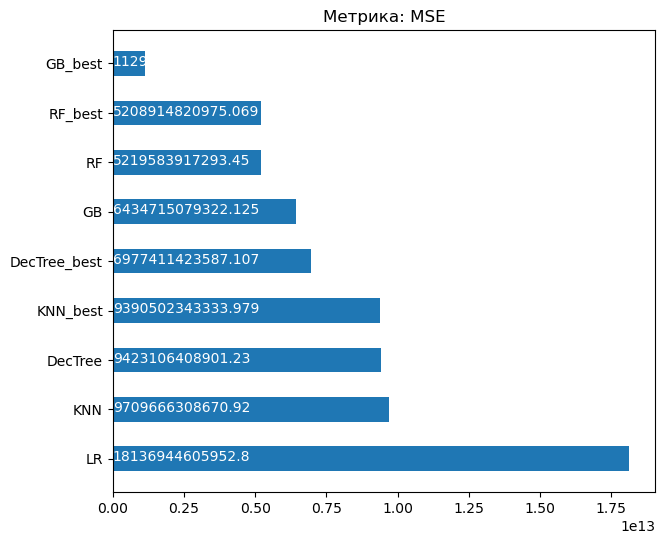

In [340]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

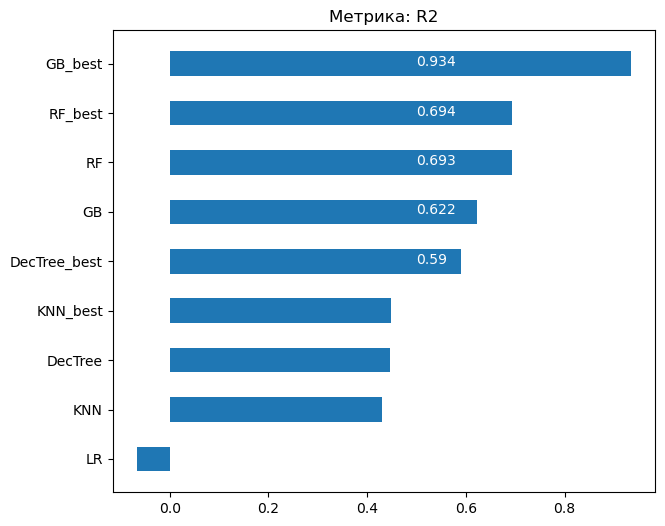

In [341]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

**Вывод: на основании трех метрик, лучшей оказалась модель градиентного бустинга c оптимальными параметрами.**